<a href="https://colab.research.google.com/github/Bangkit-Capstone-C241-BB01/BlurOrBokeh_ML_All/blob/main/%5B0%5D_TL_with_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with InceptionV3

This notebook serves as a documentation to the final model we use. It utilizes fine-tuning on the InceptionV3 pre-trained on ImageNet to do the classification task. InceptionV3 is a deep convolutional neural network (CNN) known for its effectiveness in image recognition tasks. Fine-tuning involves taking a pre-trained model and adapting it to the specific task, i.e. blur/bokeh/normal image classification.

## Setup

We use code ini [this GitHub repo](https://github.com/DTrimarchi10/confusion_matrix) to help with Confusion Matrix plotting.

In [ ]:
import os
import sys
import PIL
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

PIL.Image.MAX_IMAGE_PIXELS = None

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/My Drive/Blur or Bokeh"

data_dir = os.path.join(base_dir, "Dataset")
library_dir = os.path.join(base_dir, "Library")
serialized_data_dir = os.path.join(base_dir, "Serialized Data")
braincore_data_dir = os.path.join(data_dir, "Braincore")

sys.path.append(library_dir)
from cf_matrix import make_confusion_matrix

## Load the Dataset

We have data provided by Braincode as well as data that we found ourselves. The following script is used to combine all these data together before they are being fed into ML model. We choose image size 299x299 because it's where the images on InceptionV3 being trained on.

In [ ]:
image_size = (299, 299)
class_names = ["Blur", "Bokeh", "Normal"]

train_dir = os.path.join(braincore_data_dir, "train")
validation_dir = os.path.join(braincore_data_dir, "val")
test_dir = os.path.join(braincore_data_dir, "test")
combined_train_data_dir = os.path.join(data_dir, "Combined Training Data")


combine_train_data = False

if combine_train_data:
    import shutil

    scraped_data_dir = os.path.join(data_dir, "Scraped")
    kaggle_data_dir = os.path.join(data_dir, "Kaggle")
    train_data_dirs = [train_dir, scraped_data_dir, kaggle_data_dir]

    for train_data_dir in train_data_dirs:
        classes = os.listdir(train_data_dir)
        for cls in classes:
            cls_dir = os.path.join(train_data_dir, cls)
            combined_cls_dir = os.path.join(combined_train_data_dir, cls)
            if not os.path.exists(combined_cls_dir):
                os.makedirs(combined_cls_dir)
            for file in os.listdir(cls_dir):
                shutil.copy(os.path.join(cls_dir, file), combined_cls_dir)

train_dir = combined_train_data_dir

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="sparse"
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="sparse"
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=2000,
    class_mode="sparse",
    shuffle=False
)

Found 2910 images belonging to 3 classes.
Found 328 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


## Build the Model

### InceptionV3

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
last_layer = pre_trained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer)
x = Dense(1024, activation='relu')(x)
x = Dense(3, activation="softmax")(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

## Train, Evaluate, and Save the Model

We create custom callback to monitor if there are any weights that perform better on test set.

In [ ]:
class TestSetEvaluator(tf.keras.callbacks.Callback):
    def __init__(self, test_data, best_accuracy):
        super().__init__()
        self.test_data = test_data
        self.best_accuracy = best_accuracy

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_accuracy = self.model.evaluate(self.test_data, verbose=0)
        model_weights_filename = f"TL InceptionV3_generated_{round(test_accuracy * 100)}.h5"

        if test_accuracy > self.best_accuracy:
            self.best_accuracy = test_accuracy
            self.model.save(os.path.join(serialized_data_dir, model_weights_filename))
            print(f'\n===| Test accuracy improved to {test_accuracy:.4f} |===')

test_evaluator = TestSetEvaluator(test_generator, 0.9298)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[test_evaluator],
    epochs=20
)

Epoch 1/20
90/90 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9917

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



===| Test accuracy improved to 0.9474 |===
90/90 [==============================] - 152s 2s/step - loss: 0.0231 - accuracy: 0.9917 - val_loss: 0.1238 - val_accuracy: 0.9719
Epoch 2/20
90/90 [==============================] - 145s 2s/step - loss: 0.0366 - accuracy: 0.9875 - val_loss: 0.0927 - val_accuracy: 0.9750
Epoch 3/20
90/90 [==============================] - 144s 2s/step - loss: 0.0174 - accuracy: 0.9941 - val_loss: 0.2016 - val_accuracy: 0.9625
Epoch 4/20
90/90 [==============================] - 141s 2s/step - loss: 0.0161 - accuracy: 0.9955 - val_loss: 0.4111 - val_accuracy: 0.9594
Epoch 5/20
90/90 [==============================] - 145s 2s/step - loss: 0.0152 - accuracy: 0.9951 - val_loss: 0.1376 - val_accuracy: 0.9688
Epoch 6/20
90/90 [==============================] - 146s 2s/step - loss: 0.0224 - accuracy: 0.9913 - val_loss: 0.1065 - val_accuracy: 0.9719
Epoch 7/20
90/90 [==============================] - 147s 2s/step - loss: 0.0241 - accuracy: 0.9913 - val_loss: 0.1667 - v

In [ ]:
model_weights_filename = "TL InceptionV3_latest.h5"

In [ ]:
model.save_weights(os.path.join(serialized_data_dir, model_weights_filename))

In [ ]:
model.load_weights(os.path.join(serialized_data_dir, model_weights_filename))

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

1/1 [==============================] - 2s 2s/step - loss: 0.3167 - accuracy: 0.9561
Test Accuracy: 0.9561


## Confusion Matrix

It seems like there is no misclassifying on blur images, which is a good thing.

In [ ]:
X_test, y_test = next(test_generator)

4/4 [==============================] - 1s 154ms/step


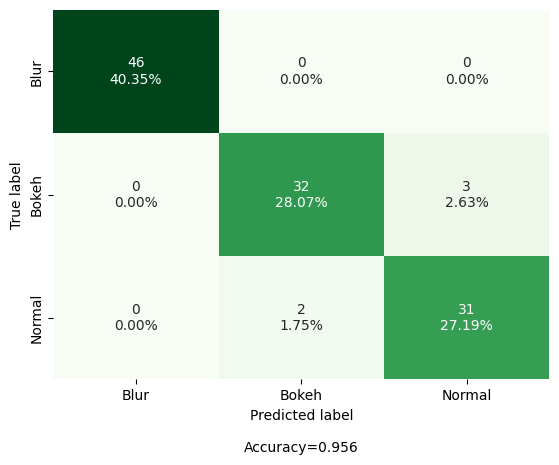

In [ ]:
test_pred = model.predict(X_test)
test_pred = tf.argmax(test_pred, axis=1)
cm = confusion_matrix(y_test, test_pred)
make_confusion_matrix(cm, categories=class_names, cmap="Greens", cbar=False)